In [1]:

# Data handling
import pandas as pd
import numpy as np


# Vizualisation (Matplotlib, Plotly, Seaborn, etc. )
import seaborn as sns
import matplotlib.pyplot as plt

# EDA (pandas-profiling, etc. )
...

# Feature Processing (Scikit-learn processing, etc. )
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder

# Machine Learning (Scikit-learn Estimators, Catboost, LightGBM, etc. )
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier


from sklearn.metrics import classification_report#, accuracy

# Hyperparameters Fine-tuning (Scikit-learn hp search, cross-validation, etc. )
...

# Other packages
import os

import warnings
warnings.filterwarnings('ignore')

In [6]:
df_school = pd.read_csv('../dataset/dataset.csv')

In [7]:
df_school['Target'].unique()

array(['Dropout', 'Graduate', 'Enrolled'], dtype=object)

In [8]:
df_school['Target'] = np.where(df_school['Target'] == 'Dropout', 'YES', 'NO')
# Convert 'Dropout_Flag' to numeric values: 1 for 'YES', 0 for 'NO'
df_school['Target'] = df_school['Target'].apply(lambda x: 1 if x == 'YES' else 0)

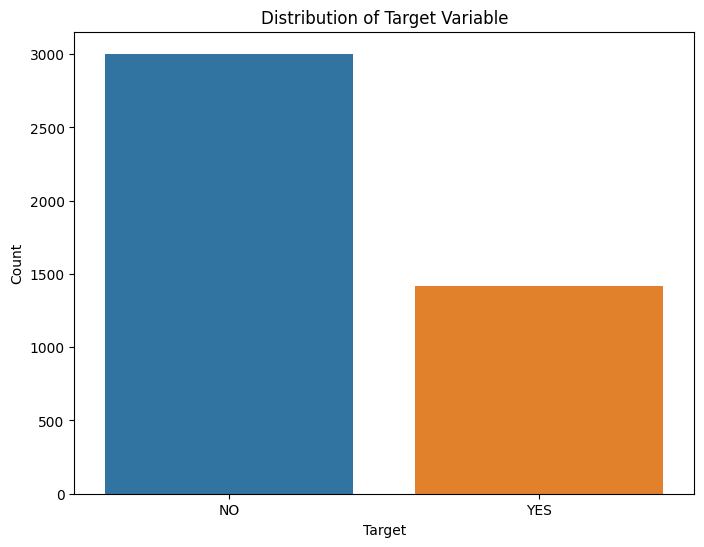

In [9]:
target_counts = df_school['Target'].value_counts()

# Create a bar plot for visualization
plt.figure(figsize=(8, 6))
sns.barplot(x=target_counts.index, y=target_counts.values)
plt.title('Distribution of Target Variable')
plt.xlabel('Target')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['NO', 'YES'])  # Ensure that x-ticks correspond to 'NO' and 'YES'
plt.show()

In [10]:
df_school['Target'].dtype

dtype('int64')

In [19]:
# Identify the numeric columns common to both 'test' and 'df_school' DataFrames
numeric_columns = list(set(df_school.select_dtypes(include='number').columns))

# Identify the categorical columns common to both 'test' and 'df_school' DataFrames
categorical_columns = list(set(df_school.select_dtypes(exclude='number').columns))

# Display the count and the list of numeric and categorical columns
print(f"There are {len(numeric_columns)} numeric columns: {numeric_columns}")
print(f"There are {len(categorical_columns)} categorical columns: {categorical_columns}")


There are 35 numeric columns: ['Scholarship holder', 'Debtor', 'International', 'Unemployment rate', 'Gender', 'Target', "Father's occupation", "Mother's qualification", 'Curricular units 1st sem (evaluations)', 'Curricular units 2nd sem (grade)', 'Tuition fees up to date', 'Application order', 'Marital status', 'Curricular units 2nd sem (credited)', 'Course', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (evaluations)', "Mother's occupation", 'GDP', 'Curricular units 1st sem (enrolled)', 'Age at enrollment', 'Application mode', 'Daytime/evening attendance', 'Curricular units 1st sem (without evaluations)', 'Educational special needs', 'Curricular units 1st sem (credited)', 'Nacionality', 'Curricular units 2nd sem (without evaluations)', 'Curricular units 2nd sem (enrolled)', "Father's qualification", 'Inflation rate', 'Previous qualification', 'Displaced']
There are 0 categorical columns: []


In [13]:
y=df_school['Target']
X=df_school.iloc[:,:-1]

In [14]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 34 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance                      4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Nacionality                                     4424 non-null   int64  
 7   Mother's qualification                          4424 non-null   int64  
 8   Father's qualification                          4424 non-null   int64  
 9   Mother's occupation                      

#### Training the Model with Logistic Regression

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score


In [17]:
# spliting the data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

import warnings
from sklearn.exceptions import ConvergenceWarning

# create the model
log_reg = LogisticRegression()

# fit the model on the training data
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=ConvergenceWarning)
    log_reg.fit(X=X_train, y=y_train)

# make predictions on the testing data
y_pred = log_reg.predict(X_test)

# calculate cross-entropy loss
cel = log_loss(y_test, y_pred)

print("Cross-Entropy Loss:", cel)


Cross-Entropy Loss: 4.4392748241963496


In [37]:
print("Accuracy Score: ",accuracy_score(y_test,y_pred))
print("Precision Score: ", precision_score(y_test, y_pred))
print("Recall Score: ", recall_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))


Accuracy Score:  0.8768361581920904
Precision Score:  0.8540772532188842
Recall Score:  0.7262773722627737
F1 Score:  0.7850098619329388


In [38]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm


array([[577,  34],
       [ 75, 199]], dtype=int64)

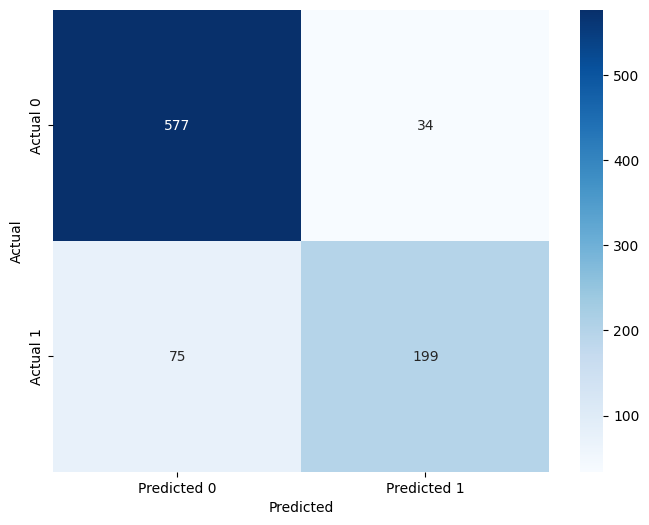

In [24]:
# Plot the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()